# Benchmark 
---

This notebook compares the decoder performance between Viterbi Decoder and Neural Decoder [1] on Convolution Codes over AWGN/BSC Channel.

Reference:
* [1] Kim, Hyeji, et al. "Communication Algorithms via Deep Learning." ICLR (2018)

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import time
import numpy as np
import commpy as cp
import tensorflow as tf
import multiprocessing as mp
from commpy.channelcoding import Trellis

from deepcom.metrics import BER, BLER       # metrics to benchmark Neural Decoder Model
from deepcom.dataset import data_genenerator, create_bsc_dataset

# Define a test dataset

In [3]:
NUM_EXAMPLES = 5000
BATCH_SIZE = 500       # depends on size of GPU, should be a factor of number_testing_sequences
BLOCK_LEN = 100        # length of a message bits
CONSTRAINT_LEN = 3     # num of shifts in Conv. Encoder
TRACE_BACK_DEPTH = 15  # (?) a parameter Viterbi Encoder

#  Generator Matrix (octal representation)
G = np.array([[0o7, 0o5]]) 
M = np.array([CONSTRAINT_LEN - 1])
trellis = Trellis(M, G, feedback=0o7)

_, Y_test = create_bsc_dataset(
    NUM_EXAMPLES, 
    100, 
    trellis, 
    error_prob=0.1, seed=1111)

# Load pre-trained Neural Decoder

In [4]:
try:
    model_path = os.path.join('../models/BiGRU_BSC.hdf5')
    print(model_path)
    model = tf.keras.models.load_model(model_path, custom_objects={'BER': BER, 'BLER': BLER})
    model.compile(optimizer='adam', loss='binary_crossentropy')
    print('Pre-trained model is loaded.')
except Exception as e:
    print(e)
    raise ValueError('Pre-trained model is not found.')

../models/BiGRU_BSC.hdf5
Pre-trained model is loaded.


# Setup Viterbi/Neural Decoder Benchmarks

In [5]:
def benchmark_neural_decoder(noisy_inputs, labels):
    
    # Preproces input and label vectors
    Y = np.reshape(labels, (-1, BLOCK_LEN, 1))
    X = np.reshape(np.array(noisy_inputs)[:, :2*BLOCK_LEN], 
                   (-1, BLOCK_LEN, 2))
    
    # Set up data generator
    test_set = data_genenerator(X, Y, BATCH_SIZE, shuffle=False)
    
    # Make predictions on batch
    decoded_bits = model.predict(
        test_set.make_one_shot_iterator(), 
        steps=len(Y) // BATCH_SIZE).round().astype(int)
    
    original_bits = np.reshape(Y, (-1, BLOCK_LEN)).astype(int)
    decoded_bits =  np.reshape(decoded_bits, (-1, BLOCK_LEN))

    # Compute hamming distances
    num_bit_errors_per_message = [cp.utilities.hamming_dist(
        x.astype(int),
        y.astype(int)
    ) for (x, y) in zip(original_bits, decoded_bits)]
    return num_bit_errors_per_message

def benchmark_viterbi(message_bits, noisy_bits, sigma):
    
    # Viterbi Decoder on Conv. Code
    decoded_bits = cp.channelcoding.viterbi_decode(
        coded_bits=noisy_bits.astype(float), 
        trellis=trellis,
        tb_depth=TRACE_BACK_DEPTH,
        decoding_type='hard') 
    
    # Compute hamming distance
    num_bit_errors_per_message = cp.utilities.hamming_dist(
        message_bits.astype(int),
        decoded_bits[:-int(M)])
    return num_bit_errors_per_message


def generate_noisy_input(message_bits, trellis, snr):
    """For every SNR_db, we generates new noisy signals
    for fair comparision."""
    
    # Encode message bit
    coded_bits = cp.channelcoding.conv_encode(message_bits, trellis)
    
    # Corrupt message on BAWGN Channel
    noisy = cp.channels.bsc(coded_bits, snr)
    
    return noisy, message_bits

In [6]:
viterbiBERs, viterbiBLERs = [], []
neuralBERs, neuralBLERs = [], []

pool = mp.Pool(processes=mp.cpu_count())
labels = np.reshape(Y_test, (-1, BLOCK_LEN)).astype(int)
try: 
    Error_Probs  = np.linspace(0.02, 0.2, 10)
    for snr in Error_Probs:
        print('[Erorr_prob]={:.2f}'.format(snr))
        
        # Generates new noisy signals
        result = pool.starmap(
            func=generate_noisy_input,  
            iterable=[(msg_bits, trellis, snr) for msg_bits in labels])
        X, Y =  zip(*result)
        
        # ###############################################
        # BENCHMARK NEURAL DECODER & VITERBI DECODER 
        # ###############################################
        t0 = time.time()
        
        neural_hamm_dists = benchmark_neural_decoder(X, Y)
        
        t1 = time.time()
        
        viterbi_hamm_dists = pool.starmap(
            func=benchmark_viterbi, 
            iterable=[(y, x, snr) for x, y in zip(X, Y)])
        
        t2 = time.time()
        
        # ################################################
        # Compute BER and BLER 
        # ################################################
        nn_ber = sum(neural_hamm_dists) / np.product(np.shape(Y))
        nn_bler = np.count_nonzero(neural_hamm_dists) / len(Y)
        
        vi_ber = sum(viterbi_hamm_dists) / np.product(np.shape(Y))
        vi_bler = np.count_nonzero(viterbi_hamm_dists) / len(Y)
        
        neuralBERs.append(nn_ber)
        neuralBLERs.append(nn_bler)            
        viterbiBERs.append(vi_ber)
        viterbiBLERs.append(vi_bler)
        print('\tNeural Decoder:  [BER]={:5.10f} [BLER]={:5.6f} -- {:3.3f}s'.format(
            nn_ber, nn_bler, t1 - t0)) 
        print('\tViterbi Decoder: [BER]={:5.10f} [BLER]={:5.6f} -- {:3.3f}s'.format(
              vi_ber, vi_bler,t2 - t1))
except Exception as e:
    print(e)
finally:
    pool.close()


[Erorr_prob]=0.02
	Neural Decoder:  [BER]=0.0013840000 [BLER]=0.084600 -- 5.352s
	Viterbi Decoder: [BER]=0.0011060000 [BLER]=0.045000 -- 19.693s
[Erorr_prob]=0.04
	Neural Decoder:  [BER]=0.0067500000 [BLER]=0.325200 -- 3.111s
	Viterbi Decoder: [BER]=0.0063320000 [BLER]=0.213000 -- 18.267s
[Erorr_prob]=0.06
	Neural Decoder:  [BER]=0.0173160000 [BLER]=0.621200 -- 3.027s
	Viterbi Decoder: [BER]=0.0172480000 [BLER]=0.457400 -- 18.253s
[Erorr_prob]=0.08
	Neural Decoder:  [BER]=0.0355220000 [BLER]=0.846200 -- 3.025s
	Viterbi Decoder: [BER]=0.0376700000 [BLER]=0.715200 -- 19.289s
[Erorr_prob]=0.10
	Neural Decoder:  [BER]=0.0602600000 [BLER]=0.960400 -- 3.045s
	Viterbi Decoder: [BER]=0.0663360000 [BLER]=0.903600 -- 17.874s
[Erorr_prob]=0.12
	Neural Decoder:  [BER]=0.0888340000 [BLER]=0.988400 -- 3.091s
	Viterbi Decoder: [BER]=0.1026180000 [BLER]=0.969400 -- 18.516s
[Erorr_prob]=0.14
	Neural Decoder:  [BER]=0.1166520000 [BLER]=0.998400 -- 3.129s
	Viterbi Decoder: [BER]=0.1357580000 [BLER]=0.991

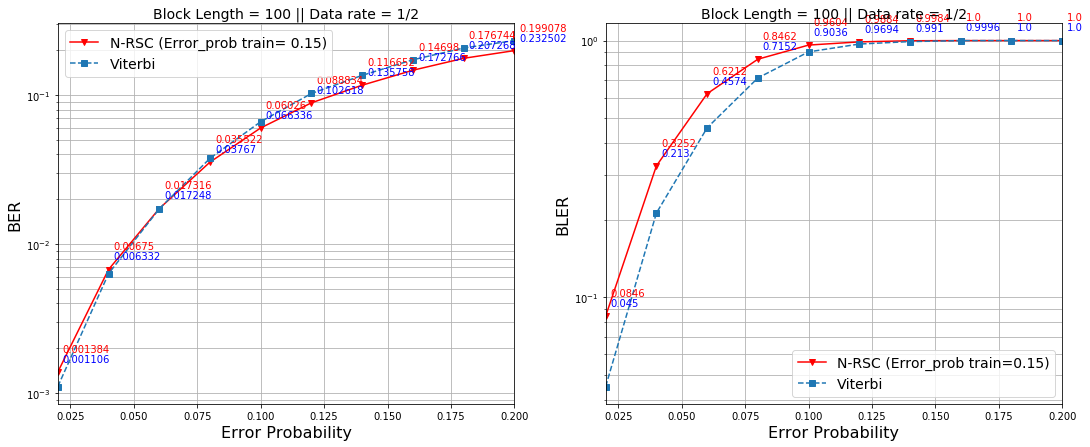

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# ###################################
# Plot Bit Error Rate (BER) Curve
# ###################################
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(Error_Probs, neuralBERs, '-vr')
plt.semilogy(Error_Probs, viterbiBERs, 's--')
plt.legend(['N-RSC (Error_prob train= 0.15)', 'Viterbi'], fontsize=14)
plt.xlabel('Error Probability', fontsize=16)
plt.xlim(xmin=Error_Probs[0], xmax=Error_Probs[-1])  # this line
plt.ylabel('BER', fontsize=16)
plt.grid(True, which='both')

for (x, y1, y2) in zip(Error_Probs, neuralBERs, viterbiBERs):
    plt.annotate(str(y1), xy=(x,y1), xytext=(5,20), textcoords='offset points', color='red')
    plt.annotate(str(y2), xy=(x,y1), xytext=(5,10), textcoords='offset points', color='blue')

# ###################################
# Plot Block Error Rate (BLER) Curve
# ###################################
plt.subplot(1, 2, 2)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(Error_Probs, neuralBLERs, '-vr')
plt.semilogy(Error_Probs, viterbiBLERs, 's--')
plt.ylabel('BLER', fontsize=16)
plt.xlabel('Error Probability', fontsize=16)
plt.legend(['N-RSC (Error_prob train=0.15)', 'Viterbi'], fontsize=14)

plt.xlim(xmin=Error_Probs[0], xmax=Error_Probs[-1])  # this line
plt.grid(True, which='both')
for (x, y1, y2) in zip(Error_Probs, neuralBLERs, viterbiBLERs):
    plt.annotate(str(y1), xy=(x,y1), xytext=(5,20), textcoords='offset points', color='red')
    plt.annotate(str(y2), xy=(x,y1), xytext=(5,10), textcoords='offset points', color='blue')

plt.savefig('result_bl100_pt015.png')